# Project: Masters thesis - structuring optimal portfolio based on selected asset classes
**Abstract:** Creating multiple asset allocation strategies based on:  
1. manually selected securities 
2. bond & multi-asset ETFs 
3. Single multi-asset ETF's portfolios 
4. SP500
And then determining best strategies based on total returs and time of entry/exit.
**Data:** Stocks & Securities data  
**Source:** https://stooq.com/


## 1. Setting-up project environment

### 1.1 Importing packages & data

In [1]:
from urllib.request import urlretrieve
from datetime import datetime
import pandas as pd
import mplfinance as mpl #https://pypi.org/project/mplfinance/
import os
import string
import re
import numpy as np
import matplotlib.pyplot as plt 

from IPython.display import display, HTML
%matplotlib inline

# Setting pandas display options
pd.options.display.max_columns = 200
pd.options.display.max_rows = 100



Useful:  
* dir() #list of variables  
* %whos #list of objects in environment  

### Research and links:  

* Markdown : https://www.markdownguide.org/basic-syntax/
* Sortino ratio: https://www.investopedia.com/terms/s/sortinoratio.asp
* Sharpe ratio: http://web.stanford.edu/~wfsharpe/art/sr/sr.htm

Libraries to explore:  
* https://www.activestate.com/blog/top-10-python-packages-for-finance-and-financial-modeling/
* https://quantlib-python-docs.readthedocs.io/en/latest/
* https://github.com/quandl/quandl-python
* https://github.com/quantopian/pyfolio
* https://gbeced.github.io/pyalgotrade/docs/v0.20/html/tutorial.html

Stooq data:
* https://www.quantstart.com/articles/an-introduction-to-stooq-pricing-data/

Portfolio analysis:
* DataCamp course: https://app.datacamp.com/learn/courses/introduction-to-portfolio-analysis-in-python


### 1.2 Establishing portfolio parameters

In [2]:
# PARAMETERS for calculations
portfolio_stocks = ['AAPLUS','MSFTUS','AMZNUS','NVDAUS'] # securities chosen  for your porfolio "SPX","V80ADE","WIG","PKO"
portfolio_weights = np.array([0.25, 0.25, 0.25 ,0.25]) # weights for your securities in portfolio. Number of weights must match number of securities
capital = 100000 #starting capital
rfr = 0.0 # risk-free-rate
target_return = 0.0 # target return for Sortino ratio

In [3]:
ticker_list = ['WIG','WIG20','^SPX','V80A.DE','^TBSP','EURPLN','USDPLN','BTC.V','XAGPLN','XAUPLN','HUG','KGH','PCF','PKO','PZU',
              'AAPL.US', 'MSFT.US', 'AMZN.US', 'GOOGL.US', 'GOOG.US', 'TSLA.US', 'NVDA.US', 'META.US', 'BRK-B.US', 'UNH.US']

# WIG - index WIG
# WIG20 - top 20 companies of WIG index
# ^SPX - S&P500 index
# V80A.DE - Multi-Aasset ETF Vanguard Life Strategy 80/20 ACC EUR denominated (Xetra exchange; IKE DM BOS)
# ^TBSP - Polish treasury bonds index
# EURPLN - eur/pln exchange rate
# USDPLN - usd/pln exchange rate
# BTC.V - bitcoin price
# XAGPLN - silver (ozt - trojan ounce - 31,1034768 g)
# XAUPLN - gold (ozt - trojan ounce - 31,1034768 g)
# HUG - Huuuge Inc (game developer; MBank portfolio)
# KGH - KGHM (raw materials extractor - copper / silver ; MBank portfolio)
# PCF - PFC Group (game developer; MBank portfolio)
# PKO - PKO BP (polish bank (state owned); MBank portfolio)
# PZU - PZU (polish insurer (state owned); MBank portfolio)

#Stooq notes:  
#Indices are prefixed by ^ e.g. ^DJI (Dow Jones Industrial), ^UK100 (FTSE100)  
#US stocks are suffixed by .US e.g. AAPL.US, MSFT.US, TSLA.US  
#Cryptocurrencies are suffixed by .V e.g. BTC.V (BitCoin)  
#UK stocks are suffixed by .UK e.g. AV.UK (Aviva)  
#Price/Earnings are suffixed by _PE.US e.g. AAPL_PE.US  


### 1.3 Downloading portfolio data from stooq.com

In [4]:
#Creating data folder
data_folder="data/"

os.makedirs(data_folder, exist_ok=True)

In [5]:
#Downloading data for each security
for ticker in ticker_list:
    interval = 'd'
    url = f'https://stooq.com/q/d/l/?s={ticker}&i={interval}'
    csv_file = data_folder + ticker + '.csv'
    urlretrieve(url, csv_file)

In [6]:
# Inspect downloaded files
path, dirs, files = next(os.walk("./data"))
print(path)
print(dirs)
print(files)

./data
[]
['AAPL.US.csv', 'AMZN.US.csv', 'BRK-B.US.csv', 'BTC.V.csv', 'EURPLN.csv', 'GOOG.US.csv', 'GOOGL.US.csv', 'HUG.csv', 'KGH.csv', 'META.US.csv', 'MSFT.US.csv', 'NVDA.US.csv', 'PCF.csv', 'PKO.csv', 'PZU.csv', 'TSLA.US.csv', 'UNH.US.csv', 'USDPLN.csv', 'V80A.DE.csv', 'WIG.csv', 'WIG20.csv', 'XAGPLN.csv', 'XAUPLN.csv', '^SPX.csv', '^TBSP.csv']


### 1.4 Creating portfolio data dictionary

In [7]:
# Creating list of dataframe names out of tickers list 
# Deleting special characters
files_clean = []
pattern = r'[' + string.punctuation + ']'
for file in ticker_list:
    sample_str = re.sub(pattern, '', file)
    files_clean.append(sample_str)
    
# Sorting to match files order
files_clean.sort()

# Adjusting order of list to match files order - manual
element = 'SPX'
del files_clean[files_clean.index(element)]
files_clean.append(element)
element = 'TBSP'
del files_clean[files_clean.index(element)]
files_clean.append(element)

#displaying list
files_clean


['AAPLUS',
 'AMZNUS',
 'BRKBUS',
 'BTCV',
 'EURPLN',
 'GOOGLUS',
 'GOOGUS',
 'HUG',
 'KGH',
 'METAUS',
 'MSFTUS',
 'NVDAUS',
 'PCF',
 'PKO',
 'PZU',
 'TSLAUS',
 'UNHUS',
 'USDPLN',
 'V80ADE',
 'WIG',
 'WIG20',
 'XAGPLN',
 'XAUPLN',
 'SPX',
 'TBSP']

In [8]:
# Create a dictionary containing security name and corresponding dataframe
securities = dict()
for i, row in enumerate(files):
    print(row)
    dfName = files_clean[i]
    dfNew = pd.read_csv("./data/"+row, index_col='Date', parse_dates=['Date'],
                date_parser=lambda x: datetime.strptime(x, '%Y-%m-%d'))
    securities[dfName] = dfNew

#Check key names
securities.keys()

AAPL.US.csv
AMZN.US.csv
BRK-B.US.csv
BTC.V.csv
EURPLN.csv
GOOG.US.csv
GOOGL.US.csv
HUG.csv
KGH.csv
META.US.csv
MSFT.US.csv
NVDA.US.csv
PCF.csv
PKO.csv
PZU.csv
TSLA.US.csv
UNH.US.csv
USDPLN.csv
V80A.DE.csv
WIG.csv
WIG20.csv
XAGPLN.csv
XAUPLN.csv
^SPX.csv
^TBSP.csv


dict_keys(['AAPLUS', 'AMZNUS', 'BRKBUS', 'BTCV', 'EURPLN', 'GOOGLUS', 'GOOGUS', 'HUG', 'KGH', 'METAUS', 'MSFTUS', 'NVDAUS', 'PCF', 'PKO', 'PZU', 'TSLAUS', 'UNHUS', 'USDPLN', 'V80ADE', 'WIG', 'WIG20', 'XAGPLN', 'XAUPLN', 'SPX', 'TBSP'])

In [9]:
# Data dictionary check
# Adding daily return and cumulative return to chosen security
securities["SPX"]["daily_return"]=securities["SPX"]["Close"].pct_change()
securities["SPX"]["cum_return"]=(securities["SPX"]["daily_return"]+1).cumprod()
securities["SPX"]

,Open,High,Low,Close,Volume,daily_return,cum_return
Date,,,,,,,
1789-05-01,0.51,0.51,0.51,0.51,NaN,NaN,NaN
1789-06-01,0.51,0.51,0.51,0.51,NaN,0.000000,1.000000
1789-07-01,0.50,0.50,0.50,0.50,NaN,-0.019608,0.980392
1789-08-01,0.50,0.51,0.50,0.51,NaN,0.020000,1.000000
1789-09-01,0.51,0.51,0.50,0.51,NaN,0.000000,1.000000
...,...,...,...,...,...,...,...
2022-11-28,4005.36,4012.27,3955.77,3963.94,2.094426e+09,-0.015444,7772.431373
2022-11-29,3964.19,3976.77,3937.65,3957.63,1.912518e+09,-0.001592,7760.058824
2022-11-30,3957.18,4080.11,3938.58,4080.11,3.721832e+09,0.030948,8000.215686


## 2. Exploaratory Data Analysis (EDA)

### 2.1 Preliminary graph analysis

AAPLUS


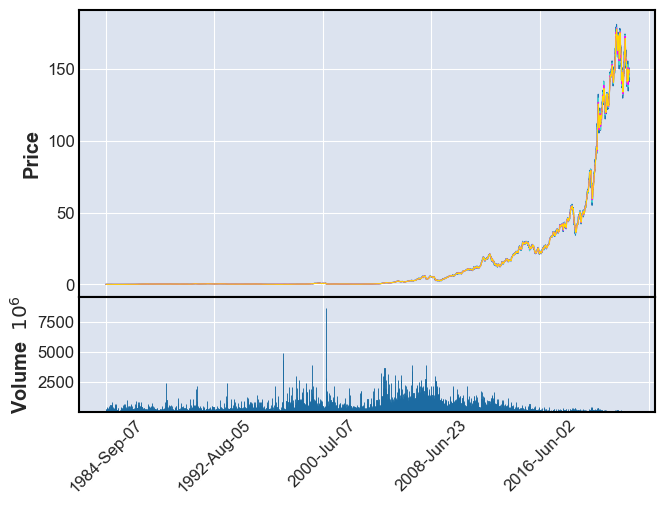

MSFTUS


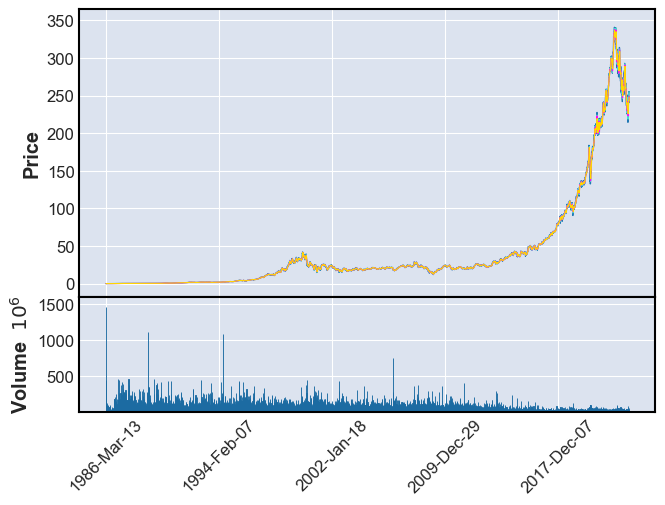

AMZNUS


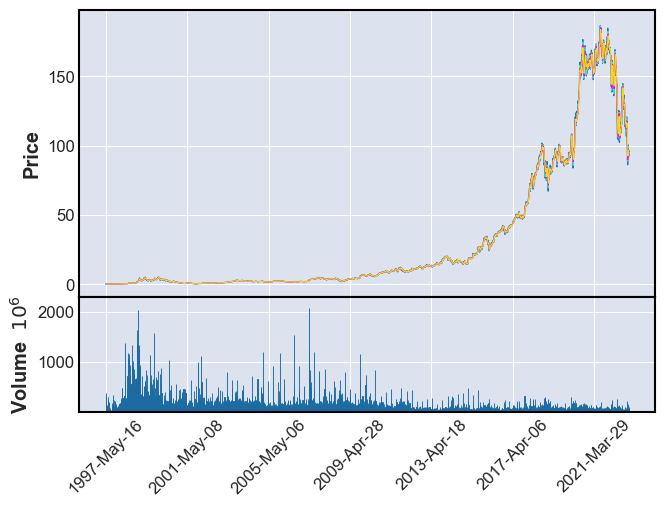

NVDAUS


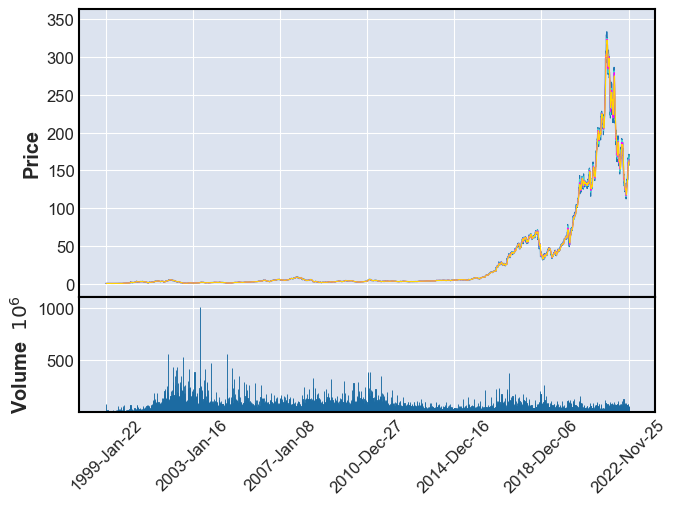

In [10]:
# Line graphs for chosen securities in portfollio
for security in portfolio_stocks:
    print(security)
    mpl.plot(securities[security], type='line', volume=True, mav=(3,6,9))

AAPLUS


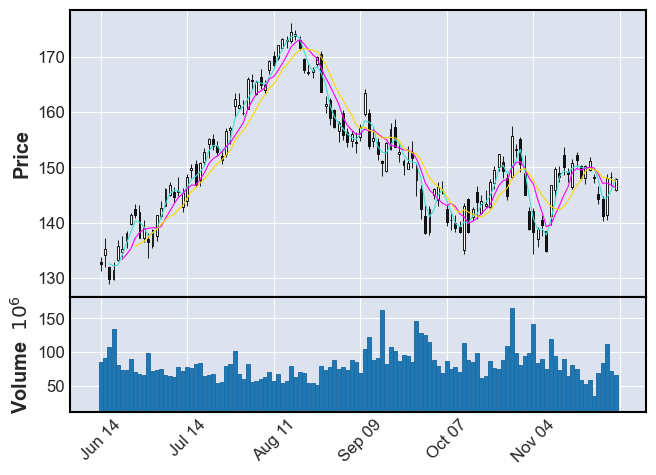

MSFTUS


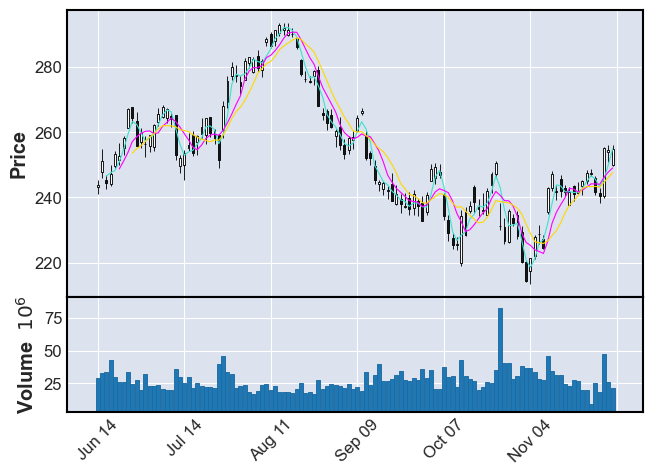

AMZNUS


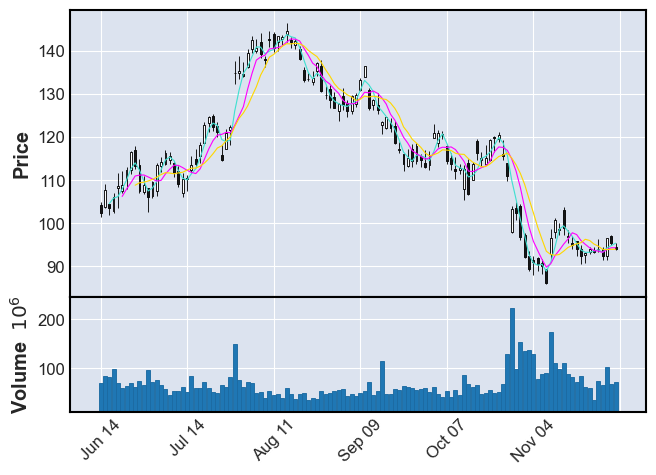

NVDAUS


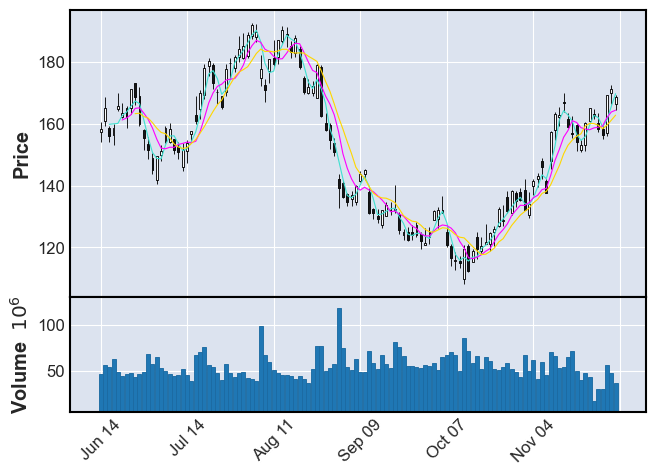

In [11]:
# Candle graphs for chosen securities in portfolio
for security in portfolio_stocks:
    print(security)
    mpl.plot(securities[security].tail(120), type='candle', volume=True, mav=(3,6,9))

### 2.2 Calculating portfolio statistics

In [12]:
#Creating portfolio

stocks = pd.DataFrame()
for item in portfolio_stocks:
    item = pd.Series(data=securities[item]["Close"], name=item)
    stocks = pd.merge(stocks, item, how='outer', left_index=True, right_index=True)
    

#Leaving only non-missing values for all observations (TBU : should we update missing values with last closing price?)
stocks = stocks[~stocks.isnull().any(axis=1)]

In [13]:
stocks

,AAPLUS,MSFTUS,AMZNUS,NVDAUS
Date,,,,
1999-01-22,0.295430,27.6209,3.0750,0.376500
1999-01-25,0.300393,28.6125,2.8095,0.415522
1999-01-26,0.308501,30.3188,2.8775,0.383359
1999-01-27,0.305835,29.8001,3.1405,0.383359
1999-01-28,0.311717,30.7529,3.0720,0.381069
...,...,...,...,...
2022-11-28,144.220000,241.7600,93.9500,158.270000
2022-11-29,141.170000,240.3300,92.4200,156.390000
2022-11-30,148.030000,255.1400,96.5400,169.230000


In [14]:
# Calculate daily returns from prices
stocks_dailyReturns = stocks.pct_change()

stocks_meanDailyReturns = stocks_dailyReturns.mean()
portfolio_return = np.sum(stocks_meanDailyReturns*portfolio_weights)
print('Average historic daily portfolio return: ', str(np.round(portfolio_return, 4) * 100) + '%')

Average historic daily portfolio return:  0.12%


In [15]:
#Calculate daily portfolio returns
portfolio_dailyReturns = pd.DataFrame()
portfolio_dailyReturns["Portfolio"]= stocks_dailyReturns.dot(portfolio_weights)
portfolio_dailyReturns

,Portfolio
Date,
1999-01-22,NaN
1999-01-25,0.017501
1999-01-26,0.008356
1999-01-27,0.016412
1999-01-28,0.005855
...,...
2022-11-28,-0.017716
2022-11-29,-0.013807
2022-11-30,0.059225


In [16]:
# Compound the percentage returns over time 
stocks_dailyCumRet=(1+stocks_dailyReturns).cumprod()
display(HTML(stocks_dailyCumRet.tail().to_html()))

portfolio_dailyCumRet=(1+portfolio_dailyReturns).cumprod()
display(portfolio_dailyCumRet.tail())

,AAPLUS,MSFTUS,AMZNUS,NVDAUS
Date,,,,
2022-11-28,488.169786,8.752792,30.552846,420.371846
2022-11-29,477.845852,8.701020,30.055285,415.378486
2022-11-30,501.066242,9.237208,31.395122,449.482072
2022-12-01,502.014013,9.220916,31.056911,455.112882
2022-12-02,500.321565,9.232864,30.611382,448.233732


,Portfolio
Date,
2022-11-28,315.656755
2022-11-29,311.298569
2022-11-30,329.735151
2022-12-01,329.890322
2022-12-02,327.289431


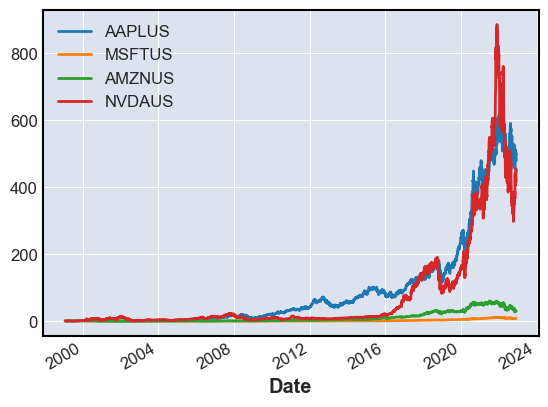

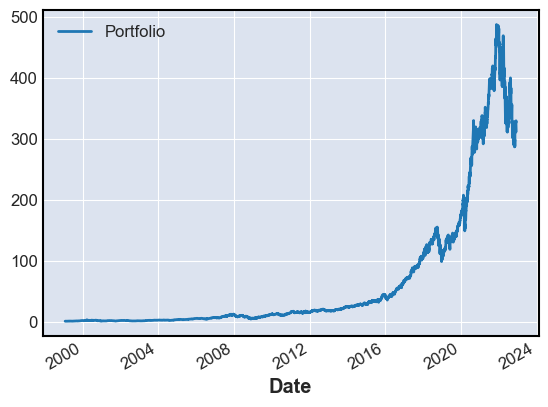

In [17]:
# Plot your cumulative return 
stocks_dailyCumRet.plot()
plt.show()
portfolio_dailyCumRet.plot()
plt.show()

In [18]:
#  The multiplication with 250 is to account for 250 trading days in a year.
stocks_covMatrix = stocks_dailyReturns.cov() * 250
display(stocks_covMatrix)
# Calculate the variance with the formula
portfolio_variance = np.dot(portfolio_weights.T, np.dot(stocks_covMatrix, portfolio_weights))


# Just converting the variance float into a percentage
print('Portfolio daily returns variance: ', str(np.round(portfolio_variance, 4) * 100) + '%')
print('Portfolio daily returns standard deviation: ', str(np.round(np.sqrt(portfolio_variance),4) * 100) + '%')

,AAPLUS,MSFTUS,AMZNUS,NVDAUS
AAPLUS,0.165693,0.059425,0.078376,0.100425
MSFTUS,0.059425,0.096294,0.069981,0.086341
AMZNUS,0.078376,0.069981,0.282549,0.105598
NVDAUS,0.100425,0.086341,0.105598,0.367496


Portfolio daily returns variance:  11.95%
Portfolio daily returns standard deviation:  34.57%


Good job! The standard deviation tells you how much the portfolio's return can deviate from the mean historical return. If a portfolio has a 12% average rate of return and a standard deviation of 4%, its return will range from 8-16%. The mean historic return of this particular portfolio is actually close to zero. With an average standard deviation of roughly 16%, this means you're getting a bad deal here! Now that you've learned how to calculate basic risk and return of a portfolio, you're ready to dive deeper into the world of portfolio analysis in the next chapters.

In [19]:
stocks

,AAPLUS,MSFTUS,AMZNUS,NVDAUS
Date,,,,
1999-01-22,0.295430,27.6209,3.0750,0.376500
1999-01-25,0.300393,28.6125,2.8095,0.415522
1999-01-26,0.308501,30.3188,2.8775,0.383359
1999-01-27,0.305835,29.8001,3.1405,0.383359
1999-01-28,0.311717,30.7529,3.0720,0.381069
...,...,...,...,...
2022-11-28,144.220000,241.7600,93.9500,158.270000
2022-11-29,141.170000,240.3300,92.4200,156.390000
2022-11-30,148.030000,255.1400,96.5400,169.230000


In [20]:
# doesn't account for weights in portfolio yet
years=(stocks.index[-1]-stocks.index[0])/ np.timedelta64(1, 'Y')

stocks_totalReturns = pd.DataFrame()

def total_return(data):
    return ((data[-1]-data[0])/data[0])
    
stocks_totalReturns["total_return"] = stocks.apply(total_return)
stocks_totalReturns["annualized_return"] = (((1+stocks_totalReturns["total_return"])**(1/years))-1)
print(stocks.index[0],' - portfolio start date')
print(stocks.index[-1],' - portfolio end date')
print(years,'years')
display(stocks_totalReturns)

1999-01-22 00:00:00  - portfolio start date
2022-12-02 00:00:00  - portfolio end date
23.860859565904843 years


,total_return,annualized_return
AAPLUS,499.321565,0.297551
MSFTUS,8.232864,0.097632
AMZNUS,29.611382,0.154178
NVDAUS,447.233732,0.291587


In [21]:
years

23.860859565904843

In [22]:
# Calculate annualized volatility from the standard deviation
# 250 accounts for 250 trading days in a year
stocks_volatility = stocks_dailyReturns.std() * np.sqrt(250)
display(stocks_volatility)

AAPLUS    0.407054
MSFTUS    0.310313
AMZNUS    0.531554
NVDAUS    0.606214
dtype: float64

In [23]:
# Calculate the Sharpe ratio 
stocks_sharpeRatio = ((stocks_totalReturns["annualized_return"] - rfr) / stocks_volatility)
display(stocks_sharpeRatio)

AAPLUS    0.730987
MSFTUS    0.314626
AMZNUS    0.290052
NVDAUS    0.480996
dtype: float64

In [24]:
portfolio_dailyReturns

,Portfolio
Date,
1999-01-22,NaN
1999-01-25,0.017501
1999-01-26,0.008356
1999-01-27,0.016412
1999-01-28,0.005855
...,...
2022-11-28,-0.017716
2022-11-29,-0.013807
2022-11-30,0.059225


In [25]:
# ZASTANOW SIE CZY TO JEST OK
portfolio = pd.DataFrame()
portfolio["Portfolio"] = pd.DataFrame(data=np.dot(stocks, portfolio_weights))
portfolio.index=stocks.index
portfolio

,Portfolio
Date,
1999-01-22,7.841957
1999-01-25,8.034479
1999-01-26,8.472040
1999-01-27,8.407448
1999-01-28,8.629421
...,...
2022-11-28,159.550000
2022-11-29,157.577500
2022-11-30,167.235000


In [26]:
# Portfolio statistics
portfolio_totalReturns = pd.DataFrame()
portfolio_totalReturns["total_return"] = portfolio.apply(total_return)
portfolio_totalReturns["annualized_return"] = (((1+portfolio_totalReturns["total_return"])**(1/years))-1)
display(portfolio_totalReturns)

,total_return,annualized_return
Portfolio,20.223017,0.136596


In [27]:
print(portfolio_dailyReturns.mean())

Portfolio    0.001204
dtype: float64


In [28]:
portfolio_variance = portfolio_dailyReturns.std()
display(portfolio_variance)

Portfolio    0.021865
dtype: float64

In [29]:
portfolio_volatility = portfolio_dailyReturns.std() * np.sqrt(250)
display(portfolio_volatility)

Portfolio    0.345717
dtype: float64

In [30]:
portfolio_sharpeRatio = ((portfolio_totalReturns["annualized_return"] - rfr) / portfolio_volatility)
display(portfolio_sharpeRatio)

Portfolio    0.395108
dtype: float64

In [31]:
stocks_totalReturns["mean_dailyReturn"]=stocks_dailyReturns.mean()*100
stocks_totalReturns["std_dailyReturn"]=stocks_dailyReturns.std()*100
stocks_totalReturns["skew_dailyReturn"]=stocks_dailyReturns.skew()
stocks_totalReturns["kurtosis_dailyReturn"]=stocks_dailyReturns.kurtosis()

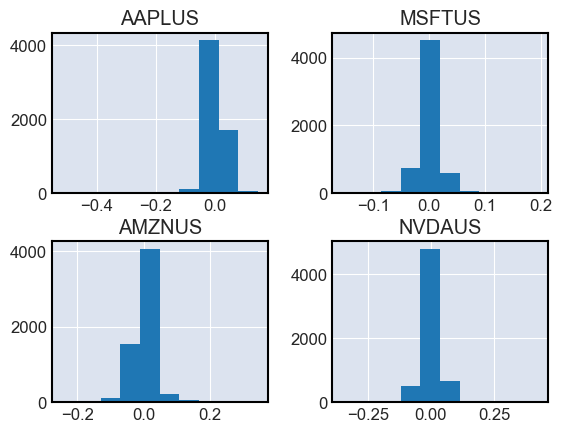

In [32]:
stocks_dailyReturns.hist()
plt.show()

In [33]:
stocks_totalReturns["sharpeRatio"]=stocks_sharpeRatio
stocks_totalReturns

,total_return,annualized_return,mean_dailyReturn,std_dailyReturn,skew_dailyReturn,kurtosis_dailyReturn,sharpeRatio
AAPLUS,499.321565,0.297551,0.138025,2.574438,-1.269598,31.194956,0.730987
MSFTUS,8.232864,0.097632,0.056271,1.962590,0.252302,9.300711,0.314626
AMZNUS,29.611382,0.154178,0.112558,3.361840,1.075112,13.121732,0.290052
NVDAUS,447.233732,0.291587,0.174758,3.834035,0.602011,11.450300,0.480996


abs(skew) > 1 - Highly skewed distribution
abs(skew) > 0.5 - Moderatly skewed distribution
abs(skew) <= 0.5 - Approximately symmetric distribution (MSFT)

kurtosis = 3 - mesocurtic (normal distribution)
kurtosis < 3 - piatycurtic (tails are shorter and thinner, central peak is lower and broader)
kurtosis > 3 - leptocurtic (tails are longer and fatter, central peak is higher and sharper (fat tailed))

In [34]:
sortino_ratio = pd.Series(index=stocks.columns, dtype='float64')
for item in stocks.columns:
    downside_returns = stocks_dailyReturns[item].loc[stocks_dailyReturns[item] < target_return]
    expected_return = stocks_dailyReturns[item].mean()
    down_stdev = downside_returns.std()
    sortino_temp = (expected_return - rfr)/down_stdev
    sortino_ratio.update(pd.Series([sortino_temp], index=[item]))

In [35]:
stocks_totalReturns["sortinoRatio"]=sortino_ratio
stocks_totalReturns

,total_return,annualized_return,mean_dailyReturn,std_dailyReturn,skew_dailyReturn,kurtosis_dailyReturn,sharpeRatio,sortinoRatio
AAPLUS,499.321565,0.297551,0.138025,2.574438,-1.269598,31.194956,0.730987,0.070031
MSFTUS,8.232864,0.097632,0.056271,1.962590,0.252302,9.300711,0.314626,0.039568
AMZNUS,29.611382,0.154178,0.112558,3.361840,1.075112,13.121732,0.290052,0.048164
NVDAUS,447.233732,0.291587,0.174758,3.834035,0.602011,11.450300,0.480996,0.066472


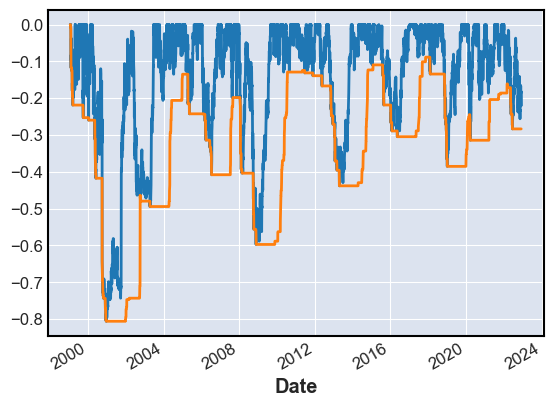

In [36]:
# Calculate the maximum value of returns using rolling().max()
roll_max = stocks['AAPLUS'].rolling(center=False, min_periods=1, window=250).max()
# Calculate daily draw-down from rolling max
daily_drawdown = stocks['AAPLUS']/roll_max - 1.0
# Calculate maximum daily draw-down
max_daily_drawdown = daily_drawdown.rolling(min_periods=1,window=250).min()
# Plot the results
daily_drawdown.plot()
max_daily_drawdown.plot()
plt.show()

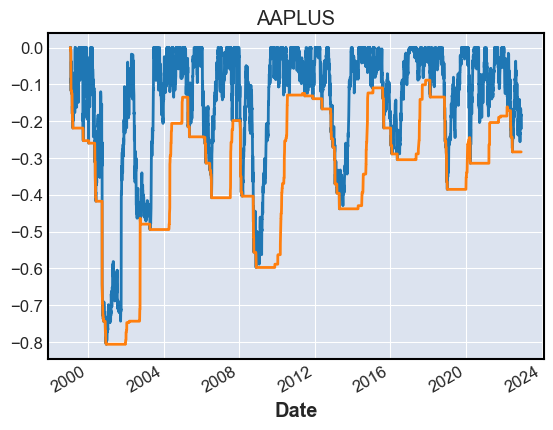

Biggest fall in analyzed period : - -0.8058


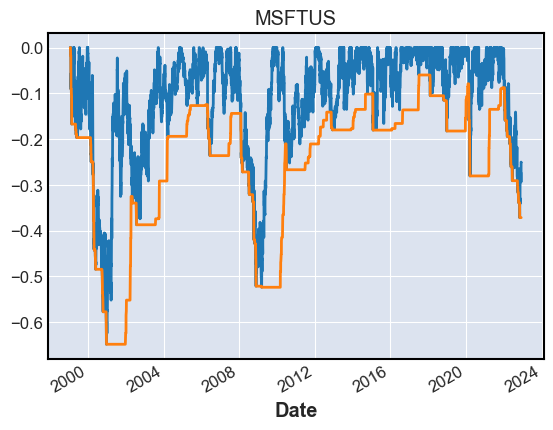

Biggest fall in analyzed period : - -0.648


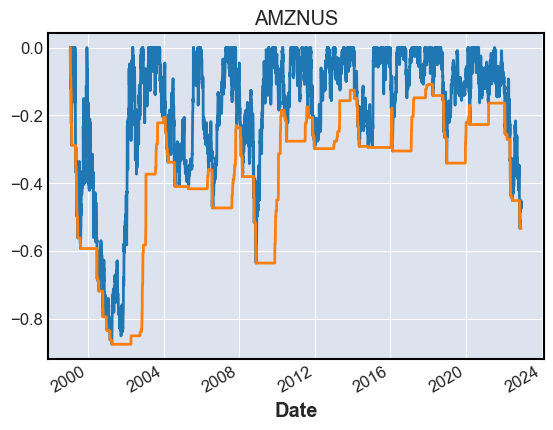

Biggest fall in analyzed period : - -0.8757


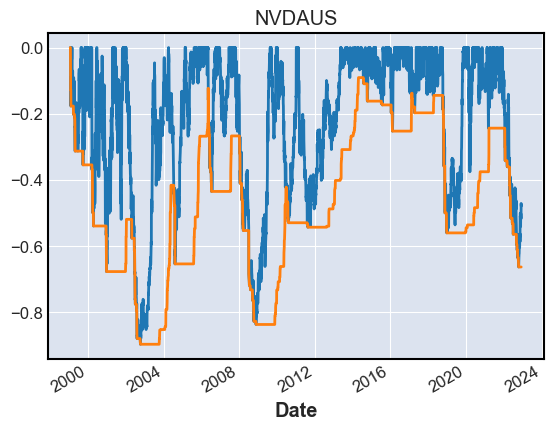

Biggest fall in analyzed period : - -0.8971


In [37]:
for stock in stocks:
    lookback_period = 250
    # Calculate the maximum value of returns using rolling().max()
    roll_max = stocks[stock].rolling(center = False, min_periods = 1, window = lookback_period).max()
    # Calculate daily draw-down from rolling max
    daily_drawdown = stocks[stock]/roll_max - 1.0
    # Calculate maximum daily draw-down
    max_daily_drawdown = daily_drawdown.rolling(center = False, min_periods = 1, window = lookback_period).min()
    daily_drawdown.plot()
    max_daily_drawdown.plot()
    plt.title(stock)
    plt.show()
    print('Biggest fall in analyzed period : -',round(min(max_daily_drawdown),4))


In [38]:
max_daily_drawdown.min()

-0.8970681290482492

In [39]:
daily_drawdown

Date
1999-01-22    0.000000
1999-01-25    0.000000
1999-01-26   -0.077404
1999-01-27   -0.077404
1999-01-28   -0.082915
                ...   
2022-11-28   -0.511725
2022-11-29   -0.517525
2022-11-30   -0.477912
2022-12-01   -0.471372
2022-12-02   -0.479362
Name: NVDAUS, Length: 6002, dtype: float64

In [40]:
# We want to calculate recovery time as well
# Our daily draw-down should be also time dependent i.e. from previous ATH

A stock is showing "momentum" if its prior 12-month average of returns is positive. The momentum factor is therefore formed by combining stocks that show consistent positive historic returns. The value factor looks at stocks that are inexpensive relative to some measure of fundamental value. For example price-to-earnings and price-to-book are typically ratios to measure "value". Let's see how our S&P500 returns relate to the returns of these factors. 